In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The scenario is as follows:  
Suits & Ties, Inc is going through a round of layoffs and they decide to survey all of their workers afterwards about their expectation of being fired themselves before the layoffs. Each worker has some number of years of seniority, X, and expectation of being fired, Y, is a continuous value with smaller values representing low expectation of being fired. The causal state of interest, D, is a dummy variable denoting that a worker was fired.

In [82]:
units = 10000
years = 40 #Range of years of seniority
t_pr = 20 #Time of discontinuity
delta = -20 #Effect size of having < t_pr years seniority

X = np.random.uniform(0, years, size=units) #Years of seniority for each unit

Y_0 = np.random.normal(years - X) #Negative relationship between X and Y_0

# All workers with < 20 yrs experience are fired
D = np.array([1 if X[i] < t_pr else 0 for i in range(units)])

Y_1 = Y_0 + delta * D #The treatment outcome for the treatment group offset by delta

Y = Y_1 * (D == 1) + Y_0 * (1 - (D == 1)) #Observed data

df = pd.DataFrame({'X': X, 'D': D, 'Y': Y, 'Y_0': Y_0, 'Y_1': Y_1})

In [3]:
df.head()

,D,X,Y,Y_0,Y_1
0,1,15.923826,3.198759,23.198759,3.198759
1,0,30.319332,9.597619,9.597619,9.597619
2,0,20.575788,19.324333,19.324333,19.324333
3,0,23.453816,16.138625,16.138625,16.138625
4,0,22.419189,17.446629,17.446629,17.446629


We've created a regression discontinuity at $X = 20$ years

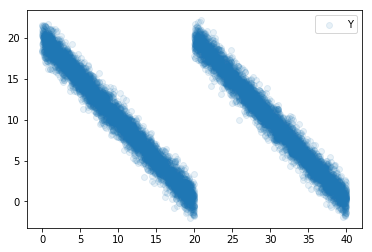

In [4]:
plt.scatter(X, Y, data=df, alpha=.1)
plt.legend('Y')

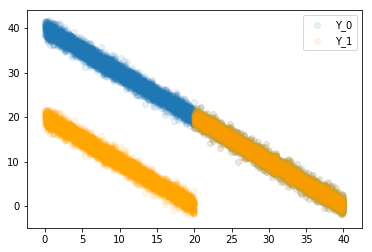

In [5]:
plt.scatter(X, Y_0, data=df, alpha=.1)
plt.scatter(X, Y_1, data=df, alpha=.1, c='orange')
plt.legend(['Y_0', 'Y_1'])

Try a linear model

In [86]:
df['intercept'] = 1
model = sm.OLS(df['Y'], df[['X', 'intercept']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     3102.
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:26:19   Log-Likelihood:                -30545.
No. Observations:               10000   AIC:                         6.109e+04
Df Residuals:                    9998   BIC:                         6.111e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.2490      0.004    -55.695      0.000      -0.258      -0.240
intercept     14.9009      0.103    144.604      0.000      14.699      15.103
==============================================================================
Omnibus:                      680.497   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.888
Skew:                           0.006   Prob(JB):                     3.63e-52
Kurtosis:                       2.246   Cond. No.                         46.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fitting a single linear model is meaningless, the estimated coefficient for $X$ is $-0.25$, one-quarter of the true value from our data generating process.

Fitting to the $Y_0$ gives the true coefficient for $X$, $-1$

In [87]:
model = sm.OLS(df['Y_0'], df[['X', 'intercept']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Y_0   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.343e+06
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:26:45   Log-Likelihood:                -14108.
No. Observations:               10000   AIC:                         2.822e+04
Df Residuals:                    9998   BIC:                         2.823e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -1.0012      0.001  -1158.825      0.000      -1.003      -1.000
intercept     40.0258      0.020   2009.828      0.000      39.987      40.065
==============================================================================
Omnibus:                        2.739   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.655
Skew:                           0.012   Prob(JB):                        0.265
Kurtosis:                       2.924   Cond. No.                         46.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
df['Y_model'] = np.array([max(Y[i], 0.) for i in range(len(Y))])
model = sm.Logit(df['Y_model'] / df['Y_model'].max(), df[['D', 'intercept']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.684414
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Y_model   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Dec 2018   Pseudo R-squ.:                -0.01322
Time:                        20:28:03   Log-Likelihood:                -6844.1
converged:                       True   LL-Null:                       -6754.9
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
D             -0.0253      0.040     -0.630      0.528      -0.104       0.053
intercept     -0.1894      0.029     -6.636      0.000      -0.245      -0.133
==============================================================================
"""

In [91]:
np.exp(results.params)

D            0.974972
intercept    0.827459
dtype: float64

Being fired $D$ is negatively associated with reported anticipation of being fired $Y$. But the logistic model used here is not a great fit for our data.

How could we recover the effect of being in the treatment from the data?  
Consider a more realistic scenario in which some fraction of workers are fired. The share of workers fired is negatively correlated with years of seniority. No workers with more than 20 years of seniority were fired. (\*Whew\* Tom from accounting has **three** kids in college)

In [9]:
units = 10000
years = 40 #Range of years of seniority
t_pr = 20 #Time of discontinuity
delta = -20 #Effect size of having < t_pr years seniority

X = np.random.uniform(0, years, size=units) #Years of seniority for each unit

Y_0 = np.random.normal(years - X) #Negative relationship between X and Y_0

p_d = 1 - X / t_pr #Having more seniority decreases the likelihood that a worker is fired
p_d = np.array([max(p_d[i], 0) for i in range(len(p_d))]) #No negative probabilites

D = np.random.binomial(1, p_d)

Y_1 = Y_0 + delta * D #The treatment outcome for the treatment group offset by delta

Y = Y_1 * (D == 1) + Y_0 * (1 - (D == 1)) #Observed data

df = pd.DataFrame({'X': X, 'D': D, 'Y': Y, 'Y_0': Y_0, 'Y_1': Y_1})

In [10]:
df.head()

,D,X,Y,Y_0,Y_1
0,0,23.919703,16.153442,16.153442,16.153442
1,0,21.971678,18.029416,18.029416,18.029416
2,1,0.115958,18.740249,38.740249,18.740249
3,1,2.481229,18.508398,38.508398,18.508398
4,0,20.856500,18.418129,18.418129,18.418129


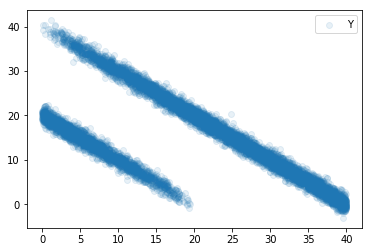

In [11]:
plt.scatter(X, Y, data=df, alpha=.1)
plt.legend('Y')

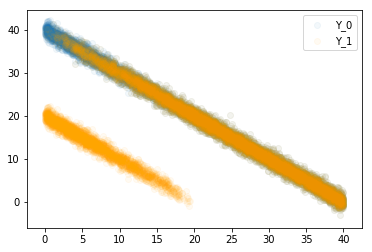

In [12]:
plt.scatter(X, Y_0, data=df, alpha=.05)
plt.scatter(X, Y_1, data=df, alpha=.05, c='orange')
plt.legend(['Y_0', 'Y_1'])

The counterfactuals for the fired workers is the same as in the previous process, the only difference is that the treatment has not been applied to every observation.

Let's try propensity score matching to recover some information about the data.

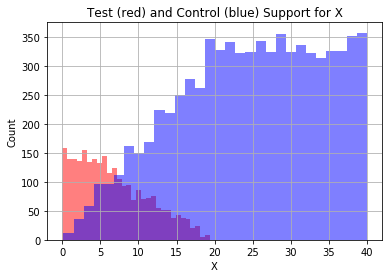

In [13]:
from causality.estimation.parametric import PropensityScoreMatching

matcher = PropensityScoreMatching()
matcher.check_support(df, 'D', {'X': 'c'})

We are lacking support for matching the full ATE, since only workers with $< 20$ years seniority can be fired in this process. Instead we can try to find the LATE for $X < 20$.

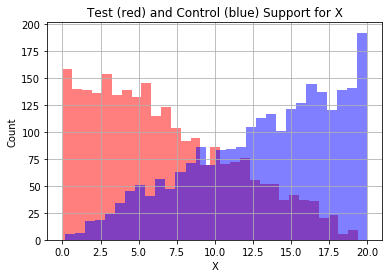

In [14]:
df_junior = df[X < 20]
matcher.check_support(df_junior, 'D', {'X': 'c'})

The support here is much improved, but may be too small for some. We will proceed with this subset of the data.

In [15]:
df_junior.head()

,D,X,Y,Y_0,Y_1
2,1,0.115958,18.740249,38.740249,18.740249
3,1,2.481229,18.508398,38.508398,18.508398
8,1,0.740545,20.537262,40.537262,20.537262
9,1,5.754304,13.481222,33.481222,13.481222
12,0,9.665151,30.252686,30.252686,30.252686


In [16]:
from statsmodels.api import WLS, OLS
from sklearn.linear_model import LogisticRegression

In [17]:
df_junior.shape

(4989, 5)

In [18]:
propensity_model = LogisticRegression(C=1e12) #Weaken the default regularization strength
X_junior = np.array(df_junior['X']).reshape(df_junior.shape[0], 1)
D_junior = np.array(df_junior['D']).reshape(df_junior.shape[0], 1)
propensity_model = propensity_model.fit(X_junior, D_junior)
df_junior['$P(d=1|X)$'] = propensity_model.predict_proba(X_junior)[:, 1]

/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [19]:
df_junior.head()

,D,X,Y,Y_0,Y_1,$P(d=1|X)$
2,1,0.115958,18.740249,38.740249,18.740249,0.929812
3,1,2.481229,18.508398,38.508398,18.508398,0.877971
8,1,0.740545,20.537262,40.537262,20.537262,0.918535
9,1,5.754304,13.481222,33.481222,13.481222,0.755580
12,0,9.665151,30.252686,30.252686,30.252686,0.529775


Compute weights for LATE  
$w_i = \frac{1}{p_i}$ for $D = 1$ and $\frac{1}{1 - p_i}$ otherwise

In [20]:
df_junior['w'] = (df_junior['D'] == 1) * 1. / df_junior['$P(d=1|X)$'] + (df_junior['D'] == 0) * 1. / (1. - df_junior['$P(d=1|X)$'])

/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_junior.head()

,D,X,Y,Y_0,Y_1,$P(d=1|X)$,w
2,1,0.115958,18.740249,38.740249,18.740249,0.929812,1.075486
3,1,2.481229,18.508398,38.508398,18.508398,0.877971,1.138990
8,1,0.740545,20.537262,40.537262,20.537262,0.918535,1.088690
9,1,5.754304,13.481222,33.481222,13.481222,0.755580,1.323486
12,0,9.665151,30.252686,30.252686,30.252686,0.529775,2.126643


Compute a weighted regression estimate for LATE

In [22]:
df_junior['intercept'] = 1
model = WLS(df_junior['Y'], df_junior[['D', 'intercept']], weights=df_junior['w'])
results = model.fit(cov_type='HC3') #Choice of covariance estimator
results.summary()

/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.750
Model:                            WLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     7174.
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:01:50   Log-Likelihood:                -16105.
No. Observations:                4989   AIC:                         3.221e+04
Df Residuals:                    4987   BIC:                         3.223e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
D            -19.4622      0.230    -84.702      0.000     -19.913     -19.012
intercept     29.8450      0.166    179.944      0.000      29.520      30.170
==============================================================================
Omnibus:                      142.398   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              362.331
Skew:                           0.022   Prob(JB):                     2.09e-79
Kurtosis:                       4.319   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

We were able to recover something close to the treatment effect!  
The coefficient estimate for $D$ is $-19$, close to the true effect, $20$

Now let's try to add a confounder into the process.  
Let $Z$ denote something that may affect the causal state and the outcome, say anxiety.

In [92]:
units = 10000
years = 40 #Range of years of seniority
Z_max = 40 #Range of confounder
t_pr = 20 #Time of discontinuity
delta = -20 #Effect size of having < t_pr years seniority

Z = np.random.uniform(0, Z_max, size=units) #Confounder, eg anxiety

X = np.random.uniform(0, years, size=units) #Years of seniority for each unit

Y_0 = np.random.normal(years - (X + Z) / 2.) #Negative relationship between X and Y_0 and between Z and Y_0

p_d = 1 - (X + Z) / t_pr #Having more seniority or anxiety decreases the likelihood that a worker is fired
p_d = np.array([max(p_d[i], 0) for i in range(len(p_d))]) #No negative probabilites

D = np.random.binomial(1, p_d)

Y_1 = Y_0 + delta * D #The treatment outcome for the treatment group offset by delta

Y = Y_1 * (D == 1) + Y_0 * (1 - (D == 1)) #Observed data

df = pd.DataFrame({'X': X, 'D': D, 'Y': Y, 'Y_0': Y_0, 'Y_1': Y_1, 'Z': Z})

In [93]:
df.head()

,D,X,Y,Y_0,Y_1,Z
0,0,36.907468,3.476143,3.476143,3.476143,38.728329
1,0,14.854052,19.784424,19.784424,19.784424,24.566949
2,0,26.740969,17.941415,17.941415,17.941415,18.325925
3,0,38.956739,21.444565,21.444565,21.444565,1.746783
4,0,14.310834,22.854698,22.854698,22.854698,15.049108


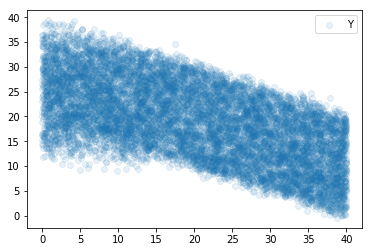

In [94]:
plt.scatter(X, Y, data=df, alpha=.1)
plt.legend('Y')

This looks a lot messier!  
We would still guess that there is a negative relationship but it is by no means obvious.

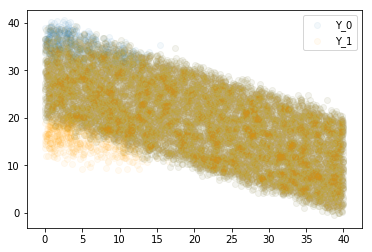

In [95]:
plt.scatter(X, Y_0, data=df, alpha=.05)
plt.scatter(X, Y_1, data=df, alpha=.05, c='orange')
plt.legend(['Y_0', 'Y_1'])

Introducing the confounder has weakened the correlation between $Y_0$ and $X$

In [96]:
X = sm.add_constant(X)
model = sm.OLS(Y_0, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                 1.005e+04
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:30:16   Log-Likelihood:                -31822.
No. Observations:               10000   AIC:                         6.365e+04
Df Residuals:                    9998   BIC:                         6.366e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.9460      0.116    257.550      0.000      29.718      30.174
x1            -0.5022      0.005   -100.230      0.000      -0.512      -0.492
==============================================================================
Omnibus:                     5378.963   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              543.247
Skew:                           0.029   Prob(JB):                    1.09e-118
Kurtosis:                       1.860   Cond. No.                         46.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the data is no longer so strongly discontinuous, fitting an initial OLS might have us conclude that the effect of $x1$ is $-.5$

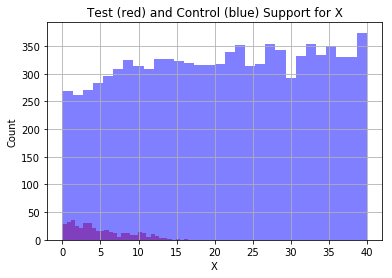

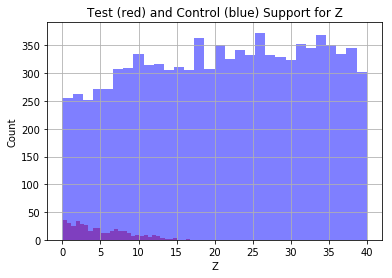

In [97]:
from causality.estimation.parametric import PropensityScoreMatching

matcher = PropensityScoreMatching()
matcher.check_support(df, 'D', {'X': 'c', 'Z': 'c'})

From the data generating process we know that only workers with $< 20$ years seniority and $< 20$ anxiety units can be fired, but is the number of observations sufficient for a meaningful estimate? Let's see...

/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


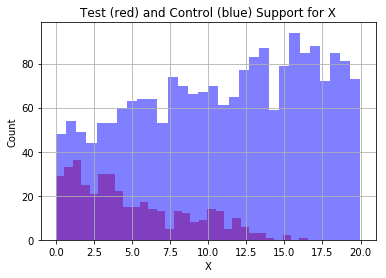

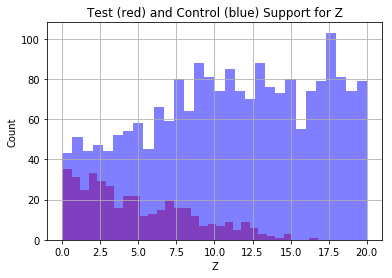

In [98]:
df_junior = df[df['X'] < 20][df['Z'] < 20]
matcher.check_support(df_junior, 'D', {'X': 'c', 'Z': 'c'})

In [99]:
df_junior.shape

(2446, 6)

In [100]:
propensity_model = LogisticRegression(C=1e12) #Weaken the default regularization strength
X_junior = np.array(df_junior['X']).reshape(df_junior.shape[0], 1)
D_junior = np.array(df_junior['D']).reshape(df_junior.shape[0], 1)
propensity_model = propensity_model.fit(X_junior, D_junior)
df_junior['$P(d=1|X)$'] = propensity_model.predict_proba(X_junior)[:, 1]

/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Compute weights for LATE  
$w_i = \frac{1}{p_i}$ for $D = 1$ and $\frac{1}{1 - p_i}$ otherwise

In [101]:
df_junior['w'] = (df_junior['D'] == 1) * 1. / df_junior['$P(d=1|X)$'] + (df_junior['D'] == 0) * 1. / (1. - df_junior['$P(d=1|X)$'])

Compute a weighted regression estimate for LATE

In [102]:
df_junior['intercept'] = 1
model = WLS(df_junior['Y'], df_junior[['D', 'intercept']], weights=df_junior['w'])
results = model.fit(cov_type='HC3') #Choice of covariance estimator
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.853
Model:                            WLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     7841.
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:30:19   Log-Likelihood:                -6612.5
No. Observations:                2446   AIC:                         1.323e+04
Df Residuals:                    2444   BIC:                         1.324e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
D            -15.4258      0.174    -88.552      0.000     -15.767     -15.084
intercept     29.4623      0.086    343.820      0.000      29.294      29.630
==============================================================================
Omnibus:                        3.977   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                4.392
Skew:                          -0.020   Prob(JB):                        0.111
Kurtosis:                       3.204   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Conditioning on only $D$ gives us an underestimate of the effect of being laid off, $-15$ instead of $-20$. This is as expected, since $Z$ is a confounder on a back-door path from $D$ to $Y$. We should be able to deal with it by including $Z$ in our regression.

In [103]:
model = WLS(df_junior['Y'], df_junior[['D', 'Z', 'intercept']], weights=df_junior['w'])
results = model.fit(cov_type='HC3') #Choice of covariance estimator
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.893
Model:                            WLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     5267.
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:30:19   Log-Likelihood:                -6226.8
No. Observations:                2446   AIC:                         1.246e+04
Df Residuals:                    2443   BIC:                         1.248e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
D            -18.0232      0.176   -102.628      0.000     -18.367     -17.679
Z             -0.3621      0.012    -29.755      0.000      -0.386      -0.338
intercept     33.5127      0.152    220.826      0.000      33.215      33.810
==============================================================================
Omnibus:                       44.264   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.844
Skew:                          -0.184   Prob(JB):                     3.05e-15
Kurtosis:                       3.721   Cond. No.                         35.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

We get something a bit better by including $Z$, now our estimate for the coefficient of $D$ is $-18$.

Could we get a more accurate estimate by restricting our support even further, for example to $X < 15$ and $Z < 15$?

/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


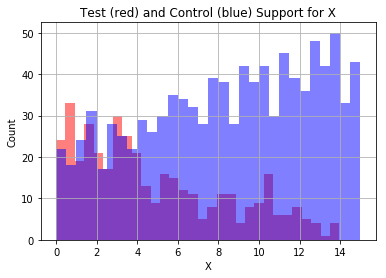

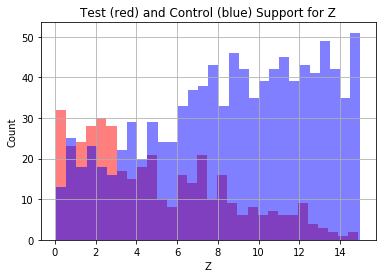

In [104]:
df_rest = df[df['X'] < 15][df['Z'] < 15]
matcher.check_support(df_rest, 'D', {'X': 'c', 'Z': 'c'})

In [105]:
propensity_model = LogisticRegression(C=1e12) #Weaken the default regularization strength
X_rest = np.array(df_rest['X']).reshape(df_rest.shape[0], 1)
D_rest = np.array(df_rest['D']).reshape(df_rest.shape[0], 1)
propensity_model = propensity_model.fit(X_rest, D_rest)
df_rest['$P(d=1|X)$'] = propensity_model.predict_proba(X_rest)[:, 1]

/home/eric/anaconda3/envs/causalInf/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [106]:
df_rest['w'] = (df_rest['D'] == 1) * 1. / df_rest['$P(d=1|X)$'] + (df_rest['D'] == 0) * 1. / (1. - df_rest['$P(d=1|X)$'])

Compute a weighted regression estimate for the further restricted LATE

In [108]:
df_rest['intercept'] = 1
model = WLS(df_rest['Y'], df_rest[['D', 'Z', 'intercept']], weights=df_rest['w'])
results = model.fit(cov_type='HC3') #Choice of covariance estimator
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.937
Model:                            WLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     6913.
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:50:53   Log-Likelihood:                -3253.0
No. Observations:                1394   AIC:                             6512.
Df Residuals:                    1391   BIC:                             6528.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
D            -19.2630      0.165   -116.916      0.000     -19.586     -18.940
Z             -0.3594      0.017    -21.319      0.000      -0.392      -0.326
intercept     35.0652      0.169    207.365      0.000      34.734      35.397
==============================================================================
Omnibus:                       30.984   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.791
Skew:                          -0.268   Prob(JB):                     2.29e-09
Kurtosis:                       3.630   Cond. No.                         27.4
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In this case we do get closer, the coefficient of $D$ is $-19$. This worked for our toy data generating process, in which there was a constant effect to be recovered, so determining the LATE is good enough.  
In the real world, subsetting like this would restrict the explanatory power of our analysis. In other words, looking at the effect of being laid off on those with $< 15$ years seniority and $< 15$ units of anxiety would only tell us something about those people and not the entire workforce.